In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import pandas as pd
import pickle

from plot_3d_helpers import expanded_detector_boundary_points, detector_boundary_points
from plot_3d_helpers import fps_clustering_downsample, get_min_dists, energy_weighted_density_sampling


# Loading File

In [2]:
use_only_true_0p0pipm = True

In [3]:
f = uproot.open("input_files/bdt_convert_superunified_bnb_ncpi0_full_spacepoints.root")

#events_to_load = 500
events_to_load = None

bdt_vars = [
    "nc_delta_score",
    "nc_pio_score",
    "numu_score",
    "numu_cc_flag",
    "single_photon_numu_score",
    "single_photon_other_score",
    "single_photon_ncpi0_score",
    "single_photon_nue_score",
    "shw_sp_n_20mev_showers",
    "shw_sp_n_20br1_showers",
]

kine_vars = [
    "kine_reco_Enu"
]

eval_vars = [
    "run",
    "subrun",
    "event",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "match_isFC",
    "truth_isCC",
    "truth_nuPdg",
    "match_completeness_energy",
    "truth_energyInside",
]

PFeval_vars = [
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "truth_single_photon",
    "truth_muonMomentum",
    "reco_showerKE",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
]

T_BDTvars_df = f["wcpselection"]["T_BDTvars"].arrays(bdt_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_kine_df = f["wcpselection"]["T_KINEvars"].arrays(kine_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_eval_df = f["wcpselection"]["T_eval"].arrays(eval_vars, library="pd", entry_start=0, entry_stop=events_to_load)
T_PFeval_df = f["wcpselection"]["T_PFeval"].arrays(PFeval_vars, library="pd", entry_start=0, entry_stop=events_to_load)

all_df = pd.concat([T_BDTvars_df, T_kine_df, T_eval_df, T_PFeval_df], axis=1)

del f 
del T_BDTvars_df
del T_kine_df
del T_eval_df
del T_PFeval_df

print(len(all_df))

11935


In [4]:
if use_only_true_0p0pipm:

    nums_protons = []
    nums_charged_pions = []
    nums_protons_35 = []
    nums_charged_pions_10 = []
    truth_pdgs = all_df["truth_pdg"].to_numpy()
    truth_mothers = all_df["truth_mother"].to_numpy()
    truth_startMomentums = all_df["truth_startMomentum"].to_numpy()
    for i in tqdm(range(all_df.shape[0])):
        num_protons = 0
        num_charged_pions = 0
        num_protons_35 = 0
        num_charged_pions_10 = 0
        truth_pdg_list = truth_pdgs[i]
        truth_mother_list = truth_mothers[i]
        truth_startMomentum_list = truth_startMomentums[i]
        if isinstance(truth_pdg_list, float) and np.isnan(truth_pdg_list):
            num_protons = -1
            num_charged_pions = -1
        else:
            for j in range(len(truth_pdg_list)):
                if truth_pdg_list[j] == 2212: # proton
                    num_protons += 1
                    if truth_startMomentum_list[j][3] - 0.938272088 > 0.035:
                        num_protons_35 += 1
                if abs(truth_pdg_list[j]) == 211: # charged pion
                    num_charged_pions += 1
                    if truth_startMomentum_list[j][3] - 0.13957039 > 0.010:
                        num_charged_pions_10 += 1

        nums_protons.append(num_protons)
        nums_charged_pions.append(num_charged_pions)
        nums_protons_35.append(num_protons_35)
        nums_charged_pions_10.append(num_charged_pions_10)
    all_df["num_true_protons"] = nums_protons
    all_df["num_true_charged_pions"] = nums_charged_pions
    all_df["num_true_protons_35"] = nums_protons_35
    all_df["num_true_charged_pions_10"] = nums_charged_pions_10

    all_df = all_df.query("num_true_protons_35==0 and num_true_charged_pions_10==0")


  0%|          | 0/11935 [00:00<?, ?it/s]

# Applying WC Inclusive Single Photon Selection

In [5]:
all_df["truth_muonMomentum_3"] = all_df["truth_muonMomentum"].to_numpy()[:, 3].astype(float)

inclusive_1g_sig_query = "(match_completeness_energy>0.1*truth_energyInside and truth_single_photon==1 and (truth_isCC==0 or (truth_isCC==1 and abs(truth_nuPdg)==14 and abs(truth_muonMomentum_3-0.105658)<0.1)))"

all_df["inclusive_1g_sig_flag"] = all_df.eval(inclusive_1g_sig_query)

print("num inclusive 1g sig:", len(all_df[all_df["inclusive_1g_sig_flag"] == 1]))
print("num inclusive 1g bkg:", len(all_df[all_df["inclusive_1g_sig_flag"] == 0]))

all_df

num inclusive 1g sig: 384
num inclusive 1g bkg: 2562


,nc_delta_score,nc_pio_score,numu_score,numu_cc_flag,single_photon_numu_score,single_photon_other_score,single_photon_ncpi0_score,single_photon_nue_score,shw_sp_n_20mev_showers,shw_sp_n_20br1_showers,...,reco_showerKE,truth_pdg,truth_mother,truth_startMomentum,num_true_protons,num_true_charged_pions,num_true_protons_35,num_true_charged_pions_10,truth_muonMomentum_3,inclusive_1g_sig_flag
3,-5.331586,1.689949,-0.825601,0.0,0.660477,0.590494,-1.302506,0.328553,3.0,3.0,...,0.096360,"[14, 2112, 111, 22, 22, 2112, 2112, 1000020040...","[0, 0, 0, 3, 3, 2, 2, 2, 2, 7, 7, 6, 6, 6, 24,...","[[0.08471828699111938, 0.024122489616274834, 1...",0,0,0,0,-1.0,False
10,-4.825025,2.521180,-1.116675,0.0,1.182581,1.538028,-2.703087,1.488157,2.0,2.0,...,0.324600,"[14, 2212, 2212, 2212, 2212, 2212, 2212, 2112,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.17176179587841034, 0.03451492637395859, 0....",8,0,0,0,-1.0,True
14,-2.275953,-1.729817,-3.821578,-1.0,0.789380,-2.677778,0.254889,-1.648902,-1.0,-1.0,...,-1.000000,"[14, 2112, 111, 22, 22, 2112, 2112, 2112, 2112...","[0, 0, 0, 3, 3, 2, 2, 2, 2, 2, 2, 9, 9, 9, 9, ...","[[-0.319776713848114, -0.35783886909484863, 1....",3,0,0,0,-1.0,False
16,-4.015980,0.015307,-1.819986,0.0,2.542870,-0.563806,0.619294,0.290034,1.0,1.0,...,0.072536,"[14, 2112, 111, 2112, 1000180400, 1000180400, ...","[0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 2, ...","[[-0.09205928444862366, 0.29297110438346863, 0...",4,0,0,0,-1.0,True
21,-2.275953,-1.729817,-3.821578,-1.0,0.789380,-2.677778,0.254889,-1.648902,-1.0,-1.0,...,-1.000000,"[14, 2112, 111, 22, 22, 2112, 2112, 1000180390...","[0, 0, 0, 3, 3, 2, 2, 2, 7, 7, 7, 7, 7, 14, 6,...","[[-0.030462907627224922, -0.1091582179069519, ...",1,0,0,0,-1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11916,-6.660765,2.132133,0.121057,0.0,0.073259,-0.302890,-1.964025,1.054270,3.0,3.0,...,0.242136,"[14, 111, 1000180400, 22, 22, 11, -11, 11, 22,...","[0, 0, 0, 2, 2, 5, 5, 4, 7, 7, 7, 8, 6, 6, 65,...","[[0.12144134938716888, 0.05993575602769852, 0....",0,0,0,0,-1.0,False
11917,-2.375397,-0.219696,-0.161863,1.0,0.364190,-0.979377,-1.668873,-1.191122,1.0,1.0,...,0.132626,"[14, 2212, 2212, 2112, 2112, 2112, 111, 2112, ...","[0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 7, 7, 6, ...","[[-0.11373105645179749, -0.006226424593478441,...",7,0,0,0,-1.0,False
11925,-4.348532,-0.576947,1.645250,1.0,-1.523661,0.642902,-0.361937,1.069494,1.0,1.0,...,-1.000000,"[14, 2212, 2212, 2212, 2212, 2112, 2112, 2112,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 9, 8, 8...","[[0.18144826591014862, 0.1593461036682129, 0.9...",4,0,0,0,-1.0,False
11928,-2.275953,-1.729817,-3.340668,-1.0,0.578930,-2.520200,0.254889,-1.648902,-1.0,-1.0,...,-1.000000,"[14, 2112, 111, 2112, 1000180400, 1000180400, ...","[0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 3, 3, 2, 2, 2, ...","[[-0.04551804065704346, -0.16581696271896362, ...",0,0,0,0,-1.0,False


In [6]:
all_df = all_df.query("kine_reco_Enu > 0")

In [7]:
"""
bool LEEana::is_singlephoton_sel(TaggerInfo& tagger_info, PFevalInfo& pfeval){
  bool flag = false;
  if (tagger_info.shw_sp_n_20mev_showers > 0 &&
    pfeval.reco_nuvtxX>5.0 && pfeval.reco_nuvtxX<250.0 &&
    tagger_info.single_photon_numu_score > 0.4 && tagger_info.single_photon_other_score > 0.2 &&
    tagger_info.single_photon_ncpi0_score > -0.05 && tagger_info.single_photon_nue_score > -1.0 &&
    tagger_info.shw_sp_n_20br1_showers==1) {flag = true;}
  return flag;
}
"""

shw_sp_n_20mev_showers_vals = all_df["shw_sp_n_20mev_showers"].to_numpy()
reco_nuvtxX_vals = all_df["reco_nuvtxX"].to_numpy()
reco_nuvtxY_vals = all_df["reco_nuvtxY"].to_numpy()
reco_nuvtxZ_vals = all_df["reco_nuvtxZ"].to_numpy()
single_photon_numu_score_vals = all_df["single_photon_numu_score"].to_numpy()
single_photon_other_score_vals = all_df["single_photon_other_score"].to_numpy()
single_photon_ncpi0_score_vals = all_df["single_photon_ncpi0_score"].to_numpy()
single_photon_nue_score_vals = all_df["single_photon_nue_score"].to_numpy()
shw_sp_n_20br1_showers_vals = all_df["shw_sp_n_20br1_showers"].to_numpy()
wc_inclusive_selected_flag = []
wc_inclusive_nc_pi0_sideband_flag = []
for i in tqdm(range(len(all_df))):
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] > -0.05 and single_photon_nue_score_vals[i] > -1.0
               and shw_sp_n_20br1_showers_vals[i] == 1):
        wc_inclusive_selected_flag.append(1)
    else:
        wc_inclusive_selected_flag.append(0)
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] < -0.05):
        wc_inclusive_nc_pi0_sideband_flag.append(1)
    else:
        wc_inclusive_nc_pi0_sideband_flag.append(0)

all_df["wc_inclusive_selected_flag"] = wc_inclusive_selected_flag
all_df["wc_inclusive_nc_pi0_sideband_flag"] = wc_inclusive_nc_pi0_sideband_flag


  0%|          | 0/2021 [00:00<?, ?it/s]

/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_96070/1321146056.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df["wc_inclusive_selected_flag"] = wc_inclusive_selected_flag
/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_96070/1321146056.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df["wc_inclusive_nc_pi0_sideband_flag"] = wc_inclusive_nc_pi0_sideband_flag


In [8]:
either_1g_sel_df = all_df.query("wc_inclusive_selected_flag == 1 or (match_isFC==1 and reco_showerKE > 0 and nc_delta_score > 2.61)")

print("num either selected:", len(either_1g_sel_df))

either_1g_sel_df[["run", "subrun", "event", "wc_inclusive_selected_flag", "nc_delta_score", "inclusive_1g_sig_flag"]]


num either selected: 142


,run,subrun,event,wc_inclusive_selected_flag,nc_delta_score,inclusive_1g_sig_flag
185,20608,244,12202,1,2.696218,False
280,20838,95,4782,1,-1.703728,True
397,20566,28,1406,1,4.513292,True
433,20573,84,4210,1,-2.296370,False
479,20491,194,9738,1,-3.992426,True
...,...,...,...,...,...,...
11563,19901,150,7536,0,3.835447,True
11644,20751,144,7223,1,4.080715,False
11823,21130,229,11473,1,-0.713701,True
11861,21246,2,150,1,-2.645091,True


# Processing Spacepoints

In [9]:
spacepoint_vars = [
    "Tcluster_spacepoints_x",
    "Tcluster_spacepoints_y",
    "Tcluster_spacepoints_z",
    "Trec_spacepoints_x",
    "Trec_spacepoints_y",
    "Trec_spacepoints_z",
    "TrueEDep_spacepoints_startx",
    "TrueEDep_spacepoints_starty",
    "TrueEDep_spacepoints_startz",
    "TrueEDep_spacepoints_endx",
    "TrueEDep_spacepoints_endy",
    "TrueEDep_spacepoints_endz",
    "TrueEDep_spacepoints_edep",
]

wanted_indices = either_1g_sel_df.index.tolist()
wanted_set = set(wanted_indices)

chunk_size = 500

spacepoints_df = pd.DataFrame()
with uproot.open("input_files/bdt_convert_superunified_bnb_ncpi0_full_spacepoints.root") as f:

    tree = f["wcpselection"]["T_spacepoints"]

    for start in tqdm(range(0, tree.num_entries, chunk_size)):  # Adjust chunk size

        stop = min(start + chunk_size, tree.num_entries)

        relevant_indices = [i for i in range(start, stop) if i in wanted_set]
        if not relevant_indices:
            continue

        curr_spacepoints_df = tree.arrays(spacepoint_vars, entry_start=start, entry_stop=stop, library="pd")

        curr_spacepoints_df.index = range(start, stop)  # Make the index reflect global entry numbers
        filtered = curr_spacepoints_df.loc[relevant_indices]

        spacepoints_df = pd.concat([spacepoints_df, filtered], ignore_index=True)
        print(f"    added {len(filtered)} events, with {len(spacepoints_df)} total in curr_spacepoints_df")     


  0%|          | 0/24 [00:00<?, ?it/s]

    added 5 events, with 5 total in curr_spacepoints_df
    added 6 events, with 11 total in curr_spacepoints_df
    added 7 events, with 18 total in curr_spacepoints_df
    added 6 events, with 24 total in curr_spacepoints_df
    added 5 events, with 29 total in curr_spacepoints_df
    added 3 events, with 32 total in curr_spacepoints_df
    added 7 events, with 39 total in curr_spacepoints_df
    added 6 events, with 45 total in curr_spacepoints_df
    added 8 events, with 53 total in curr_spacepoints_df
    added 5 events, with 58 total in curr_spacepoints_df
    added 6 events, with 64 total in curr_spacepoints_df
    added 11 events, with 75 total in curr_spacepoints_df
    added 4 events, with 79 total in curr_spacepoints_df
    added 7 events, with 86 total in curr_spacepoints_df
    added 5 events, with 91 total in curr_spacepoints_df
    added 8 events, with 99 total in curr_spacepoints_df
    added 3 events, with 102 total in curr_spacepoints_df
    added 5 events, with 107 t

In [10]:
spacepoints_df


,Tcluster_spacepoints_x,Tcluster_spacepoints_y,Tcluster_spacepoints_z,Trec_spacepoints_x,Trec_spacepoints_y,Trec_spacepoints_z,TrueEDep_spacepoints_startx,TrueEDep_spacepoints_starty,TrueEDep_spacepoints_startz,TrueEDep_spacepoints_endx,TrueEDep_spacepoints_endy,TrueEDep_spacepoints_endz,TrueEDep_spacepoints_edep
0,"[234.51298828125, 234.51298828125, 234.7331787...","[-11.933788299560547, -12.106993103027344, -11...","[730.75, 731.05, 729.85, 730.45, 730.75, 730.7...","[240.4583984375, 240.4583984375, 240.458398437...","[-8.469683837890624, -8.642888641357422, -8.29...","[719.95, 720.25, 720.25, 719.05, 719.65, 719.6...","[246.02420043945312, 189.2332000732422, 189.23...","[16.813196182250977, 17.565528869628906, 17.56...","[630.1065063476562, 636.5733032226562, 636.573...","[246.02420043945312, 189.2331085205078, 189.22...","[16.813194274902344, 17.56553077697754, 17.565...","[630.1065063476562, 636.5733032226562, 636.574...","[0.06060215085744858, 0.0001688865158939734, 0..."
1,"[5.5049999237060545, 5.5049999237060545, 5.725...","[51.37281494140625, 51.19961242675781, 51.8057...","[110.5001220703125, 110.8001220703125, 110.65,...","[5.5049999237060545, 5.5049999237060545, 5.725...","[51.37281494140625, 51.19961242675781, 51.8057...","[110.5001220703125, 110.8001220703125, 110.65,...","[4.603208541870117, 24.83237648010254, 24.8323...","[42.04557418823242, 34.55050277709961, 34.5505...","[166.72824096679688, 184.8978271484375, 184.89...","[7.911688804626465, 24.832548141479492, 24.826...","[41.4507942199707, 34.55055236816406, 34.55180...","[170.03497314453125, 184.89785766601562, 184.9...","[0.03954397514462471, 0.5618975758552551, 8.73..."
2,"[192.2345947265625, 192.2345947265625, 192.454...","[88.43865966796875, 88.09224853515624, 89.1314...","[238.8999755859375, 239.4999755859375, 238.299...","[192.2345947265625, 192.2345947265625, 192.454...","[88.43865966796875, 88.09224853515624, 88.2654...","[238.8999755859375, 239.4999755859375, 238.599...","[155.24278259277344, 155.24278259277344, 155.2...","[78.78129577636719, 78.78129577636719, 78.7826...","[248.7079620361328, 248.7079620361328, 248.707...","[155.2427215576172, 155.25840759277344, 155.26...","[78.78136444091797, 78.78263854980469, 78.7829...","[248.708251953125, 248.70721435546875, 248.707...","[2.1249067783355713, 7.733961582183838, 4.8874..."
3,"[190.6931884765625, 190.6931884765625, 190.913...","[-70.47714233398438, -71.51638793945312, -70.5...","[214.45, 214.45, 214.2999267578125, 214.299951...","[190.6931884765625, 190.91339111328125, 190.91...","[-71.51638793945312, -71.60300903320312, -71.0...","[214.45, 214.299951171875, 215.199951171875, 2...","[235.69143676757812, 249.00660705566406, 174.1...","[-104.05420684814453, -103.94232940673828, -10...","[282.1332702636719, 271.85845947265625, 206.30...","[240.55348205566406, 244.97845458984375, 188.1...","[-102.00424194335938, -100.80908203125, -41.35...","[282.1421813964844, 273.6695861816406, 144.265...","[0.017810730263590813, 0.04213860630989075, 0...."
4,"[139.3865966796875, 139.3865966796875, 139.386...","[51.719140625, 52.41195068359375, 52.238757324...","[390.7, 391.3, 391.6, 391.9, 392.1999755859375...","[144.67139892578126, 144.67139892578126, 144.6...","[52.49855346679688, 52.844964599609376, 52.325...","[389.95, 389.95, 390.25, 390.25, 390.25, 390.5...","[108.37574005126953, 42.62913513183594, 45.482...","[24.981948852539062, -15.86523151397705, 37.63...","[344.9121398925781, 379.9638366699219, 369.759...","[108.3758316040039, 43.276390075683594, 46.579...","[24.98196029663086, 29.22142219543457, 19.9904...","[344.9122314453125, 369.5206604003906, 393.586...","[0.5217533111572266, 0.004631559364497662, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,"[25.543199157714845, 25.763400268554687, 25.76...","[33.35921020507813, 33.35921020507813, 33.0128...","[776.49970703125, 776.49970703125, 776.4997558...","[36.5531982421875, 36.5531982421875, 36.553198...","[43.058221435546876, 43.40

In [11]:
spacepoints = {}
for col in spacepoints_df.columns:
    spacepoints[col] = spacepoints_df[col].to_numpy()


In [12]:
#num_events = 100
num_events = either_1g_sel_df.shape[0]

Tcluster_spacepoints = []
Trec_spacepoints = []
TrueEDep_spacepoints = []
TrueEDep_spacepoints_edep = []
for event_i in tqdm(range(num_events)):
    Tcluster_spacepoints.append(np.stack([spacepoints["Tcluster_spacepoints_x"][event_i],
                                         spacepoints["Tcluster_spacepoints_y"][event_i],
                                         spacepoints["Tcluster_spacepoints_z"][event_i]], axis=-1))
    Trec_spacepoints.append(np.stack([spacepoints["Trec_spacepoints_x"][event_i],
                                      spacepoints["Trec_spacepoints_y"][event_i],
                                      spacepoints["Trec_spacepoints_z"][event_i]], axis=-1))
    starts = np.stack([spacepoints["TrueEDep_spacepoints_startx"][event_i],
                       spacepoints["TrueEDep_spacepoints_starty"][event_i],
                       spacepoints["TrueEDep_spacepoints_startz"][event_i]], axis=-1)
    midpoints = np.stack([(np.array(spacepoints["TrueEDep_spacepoints_startx"][event_i]) + np.array(spacepoints["TrueEDep_spacepoints_endx"][event_i]))/2,
                          (np.array(spacepoints["TrueEDep_spacepoints_starty"][event_i]) + np.array(spacepoints["TrueEDep_spacepoints_endy"][event_i]))/2,
                          (np.array(spacepoints["TrueEDep_spacepoints_startz"][event_i]) + np.array(spacepoints["TrueEDep_spacepoints_endz"][event_i]))/2], axis=-1)
    ends = np.stack([spacepoints["TrueEDep_spacepoints_endx"][event_i],
                     spacepoints["TrueEDep_spacepoints_endy"][event_i],
                     spacepoints["TrueEDep_spacepoints_endz"][event_i]], axis=-1)
    TrueEDep_spacepoints.append(np.concatenate([starts, midpoints, ends], axis=0))

    # assuming a third of the energy at the start, midpoint, and end
    TrueEDep_spacepoints_edep.append(np.concatenate([np.array(spacepoints["TrueEDep_spacepoints_edep"][event_i])/3,
                                                    np.array(spacepoints["TrueEDep_spacepoints_edep"][event_i])/3,
                                                    np.array(spacepoints["TrueEDep_spacepoints_edep"][event_i])/3], axis=0))


  0%|          | 0/142 [00:00<?, ?it/s]

# Downsample Spacepoints

In [13]:
true_nu_vtx_arr = either_1g_sel_df[["truth_vtxX", "truth_vtxY", "truth_vtxZ"]].to_numpy()
reco_nu_vtx_arr = either_1g_sel_df[["reco_nuvtxX", "reco_nuvtxY", "reco_nuvtxZ"]].to_numpy()

close_to_reco_nu_vtx_threshold = 200
recalculate_downsampling = True
if recalculate_downsampling:
    downsampled_Tcluster_spacepoints = []
    downsampled_Trec_spacepoints = []
    downsampled_TrueEDep_spacepoints = []
    for event_i in tqdm(range(num_events)):

        nearby_reco_nu_vtx_indices = np.where(np.sqrt((Tcluster_spacepoints[event_i][:, 0] - reco_nu_vtx_arr[event_i][0])**2
                                                    + (Tcluster_spacepoints[event_i][:, 1] - reco_nu_vtx_arr[event_i][1])**2
                                                    + (Tcluster_spacepoints[event_i][:, 2] - reco_nu_vtx_arr[event_i][2])**2) < close_to_reco_nu_vtx_threshold)[0]
        Tcluster_spacepoints_near_reco_nu_vtx = Tcluster_spacepoints[event_i][nearby_reco_nu_vtx_indices, :]
        downsampled_Tcluster_spacepoints.append(fps_clustering_downsample(Tcluster_spacepoints_near_reco_nu_vtx, 500))

        downsampled_Trec_spacepoints.append(fps_clustering_downsample(Trec_spacepoints[event_i], 200))

        downsampled_TrueEDep_spacepoints.append(energy_weighted_density_sampling(TrueEDep_spacepoints[event_i], TrueEDep_spacepoints_edep[event_i], 500))
        

    with open("downsampled_spacepoints.pkl", "wb") as f:
        pickle.dump((downsampled_Tcluster_spacepoints, downsampled_Trec_spacepoints, downsampled_TrueEDep_spacepoints), f)
else:
    with open("downsampled_spacepoints.pkl", "rb") as f:
        downsampled_Tcluster_spacepoints, downsampled_Trec_spacepoints, downsampled_TrueEDep_spacepoints = pickle.load(f)


  0%|          | 0/142 [00:00<?, ?it/s]

# Categorize Spacepoints

In [14]:
real_nu_reco_nu_downsampled_spacepoints = []
real_nu_reco_cosmic_downsampled_spacepoints = []
real_cosmic_reco_nu_downsampled_spacepoints = []
real_cosmic_reco_cosmic_downsampled_spacepoints = []
far_from_vtx_downsampled_spacepoints = []

close_to_true_nu_spacepoint_threshold = 5
close_to_reco_nu_spacepoint_threshold = 5

for event_i in range(num_events):

    if len(downsampled_Tcluster_spacepoints[event_i]) == 0:
        real_nu_reco_cosmic_downsampled_spacepoints.append(np.empty((0, 3)))
        real_nu_reco_nu_downsampled_spacepoints.append(np.empty((0, 3)))
        real_cosmic_reco_nu_downsampled_spacepoints.append(np.empty((0, 3)))
        real_cosmic_reco_cosmic_downsampled_spacepoints.append(np.empty((0, 3)))
        far_from_vtx_downsampled_spacepoints.append(np.empty((0, 3)))
        continue

    # for T_cluster spacepoints, noting distances to true nu and reco nu spacepoints, and which are close to the reco nu vtx
    min_truth_dists = get_min_dists(downsampled_Tcluster_spacepoints[event_i][:, :3], downsampled_TrueEDep_spacepoints[event_i][:, :3])
    min_reco_nu_dists = get_min_dists(downsampled_Tcluster_spacepoints[event_i][:, :3], downsampled_Trec_spacepoints[event_i][:, :3])

    # assign features to spacepoints here
    close_to_truth_indices = np.where(min_truth_dists < close_to_true_nu_spacepoint_threshold)[0]
    far_from_truth_indices = np.where(min_truth_dists >= close_to_true_nu_spacepoint_threshold)[0]
    close_to_reco_nu_indices = np.where(min_reco_nu_dists < close_to_reco_nu_spacepoint_threshold)[0]
    far_from_reco_nu_indices = np.where(min_reco_nu_dists >= close_to_reco_nu_spacepoint_threshold)[0]

    # categorize spacepoints here
    real_nu_reco_nu_indices = np.intersect1d(close_to_reco_nu_indices, close_to_truth_indices)
    real_nu_reco_cosmic_indices = np.intersect1d(far_from_reco_nu_indices, close_to_truth_indices)
    real_cosmic_reco_nu_indices = np.intersect1d(close_to_reco_nu_indices, far_from_truth_indices)
    real_cosmic_reco_cosmic_indices = np.intersect1d(far_from_reco_nu_indices, far_from_truth_indices)

    real_nu_reco_cosmic_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_nu_reco_cosmic_indices, :])
    real_nu_reco_nu_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_nu_reco_nu_indices, :])
    real_cosmic_reco_nu_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_cosmic_reco_nu_indices, :])
    real_cosmic_reco_cosmic_downsampled_spacepoints.append(downsampled_Tcluster_spacepoints[event_i][real_cosmic_reco_cosmic_indices, :])


# Histogram

In [15]:
num_real_nu_reco_nu_spacepoints = []
num_real_nu_reco_cosmic_spacepoints = []
num_real_cosmic_reco_nu_spacepoints = []
num_real_cosmic_reco_cosmic_spacepoints = []

for event_i in range(num_events):
    num_real_nu_reco_nu_spacepoints.append(len(real_nu_reco_nu_downsampled_spacepoints[event_i]))
    num_real_nu_reco_cosmic_spacepoints.append(len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]))
    num_real_cosmic_reco_nu_spacepoints.append(len(real_cosmic_reco_nu_downsampled_spacepoints[event_i]))
    num_real_cosmic_reco_cosmic_spacepoints.append(len(real_cosmic_reco_cosmic_downsampled_spacepoints[event_i]))

    if len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]) > 50:
        print(event_i, len(real_nu_reco_cosmic_downsampled_spacepoints[event_i]))

either_1g_sel_df["num_real_nu_reco_nu_spacepoints"] = num_real_nu_reco_nu_spacepoints
either_1g_sel_df["num_real_nu_reco_cosmic_spacepoints"] = num_real_nu_reco_cosmic_spacepoints
either_1g_sel_df["num_real_cosmic_reco_nu_spacepoints"] = num_real_cosmic_reco_nu_spacepoints
either_1g_sel_df["num_real_cosmic_reco_cosmic_spacepoints"] = num_real_cosmic_reco_cosmic_spacepoints


13 78
116 67
137 68


/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_96070/981059640.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  either_1g_sel_df["num_real_nu_reco_nu_spacepoints"] = num_real_nu_reco_nu_spacepoints
/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_96070/981059640.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  either_1g_sel_df["num_real_nu_reco_cosmic_spacepoints"] = num_real_nu_reco_cosmic_spacepoints
/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_96070/981059640.p

In [16]:
wc_inclusive_1g_sel_df = either_1g_sel_df.query("wc_inclusive_selected_flag == 1")
print("num WC inclusive 1g sig sel:", len(wc_inclusive_1g_sel_df[wc_inclusive_1g_sel_df["inclusive_1g_sig_flag"] == 1]))
print("num WC inclusive 1g bkg sel:", len(wc_inclusive_1g_sel_df[wc_inclusive_1g_sel_df["inclusive_1g_sig_flag"] == 0]))

wc_nc_delta_1g_sel_df = either_1g_sel_df.query("match_isFC==1 and reco_showerKE > 0 and nc_delta_score > 2.61")
print("num WC NC Delta 1g sig sel:", len(wc_nc_delta_1g_sel_df[wc_nc_delta_1g_sel_df["inclusive_1g_sig_flag"] == 1]))
print("num WC NC Delta 1g bkg sel:", len(wc_nc_delta_1g_sel_df[wc_nc_delta_1g_sel_df["inclusive_1g_sig_flag"] == 0]))


num WC inclusive 1g sig sel: 59
num WC inclusive 1g bkg sel: 55
num WC NC Delta 1g sig sel: 22
num WC NC Delta 1g bkg sel: 31


In [17]:
inclusive_sel_real_nu_reco_nu = wc_inclusive_1g_sel_df["num_real_nu_reco_nu_spacepoints"].to_numpy()
inclusive_sel_real_nu_reco_cosmic = wc_inclusive_1g_sel_df["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
inclusive_sel_real_cosmic_reco_nu = wc_inclusive_1g_sel_df["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
inclusive_sel_real_cosmic_reco_cosmic = wc_inclusive_1g_sel_df["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()

inclusive_sig_sel_real_nu_reco_nu = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_nu_reco_nu_spacepoints"].to_numpy()
inclusive_sig_sel_real_nu_reco_cosmic = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
inclusive_sig_sel_real_cosmic_reco_nu = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
inclusive_sig_sel_real_cosmic_reco_cosmic = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()

inclusive_bkg_sel_real_nu_reco_nu = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_nu_reco_nu_spacepoints"].to_numpy()
inclusive_bkg_sel_real_nu_reco_cosmic = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
inclusive_bkg_sel_real_cosmic_reco_nu = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
inclusive_bkg_sel_real_cosmic_reco_cosmic = wc_inclusive_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()


nc_delta_sel_real_nu_reco_nu = wc_nc_delta_1g_sel_df["num_real_nu_reco_nu_spacepoints"].to_numpy()
nc_delta_sel_real_nu_reco_cosmic = wc_nc_delta_1g_sel_df["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
nc_delta_sel_real_cosmic_reco_nu = wc_nc_delta_1g_sel_df["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
nc_delta_sel_real_cosmic_reco_cosmic = wc_nc_delta_1g_sel_df["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()

nc_delta_sig_sel_real_nu_reco_nu = wc_nc_delta_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_nu_reco_nu_spacepoints"].to_numpy()
nc_delta_sig_sel_real_nu_reco_cosmic = wc_nc_delta_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
nc_delta_sig_sel_real_cosmic_reco_nu = wc_nc_delta_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
nc_delta_sig_sel_real_cosmic_reco_cosmic = wc_nc_delta_1g_sel_df.query("inclusive_1g_sig_flag == 1")["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()

nc_delta_bkg_sel_real_nu_reco_nu = wc_nc_delta_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_nu_reco_nu_spacepoints"].to_numpy()
nc_delta_bkg_sel_real_nu_reco_cosmic = wc_nc_delta_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_nu_reco_cosmic_spacepoints"].to_numpy()
nc_delta_bkg_sel_real_cosmic_reco_nu = wc_nc_delta_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_cosmic_reco_nu_spacepoints"].to_numpy()
nc_delta_bkg_sel_real_cosmic_reco_cosmic = wc_nc_delta_1g_sel_df.query("inclusive_1g_sig_flag == 0")["num_real_cosmic_reco_cosmic_spacepoints"].to_numpy()


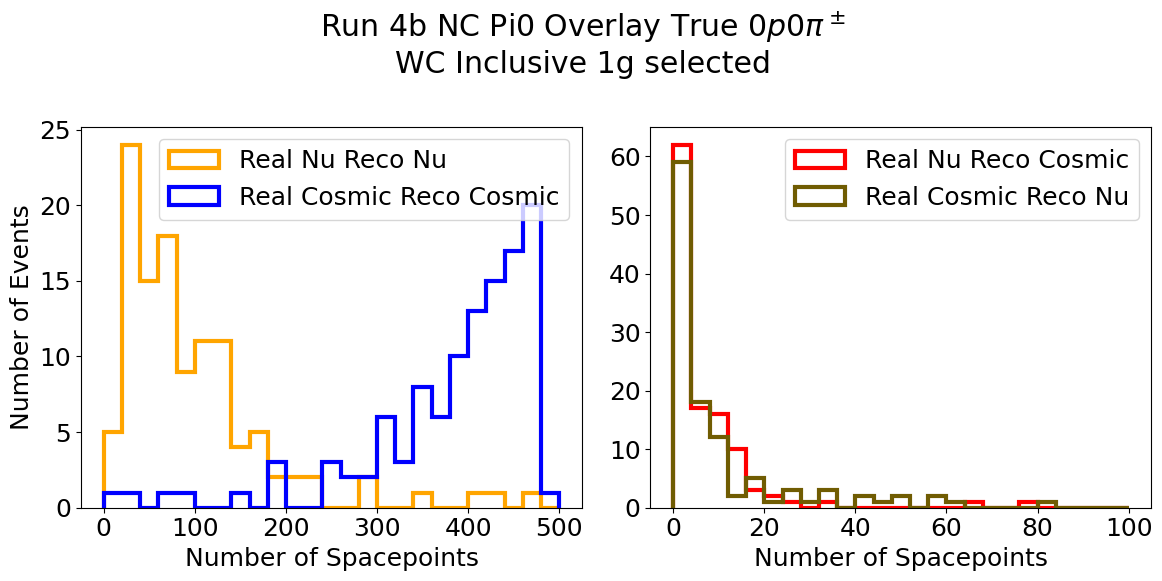

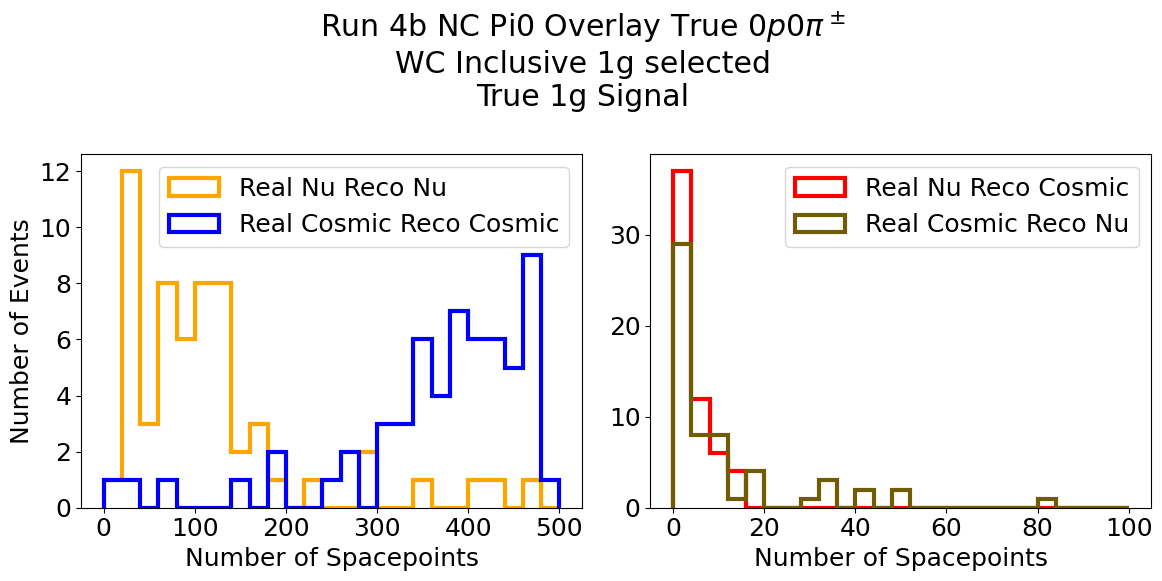

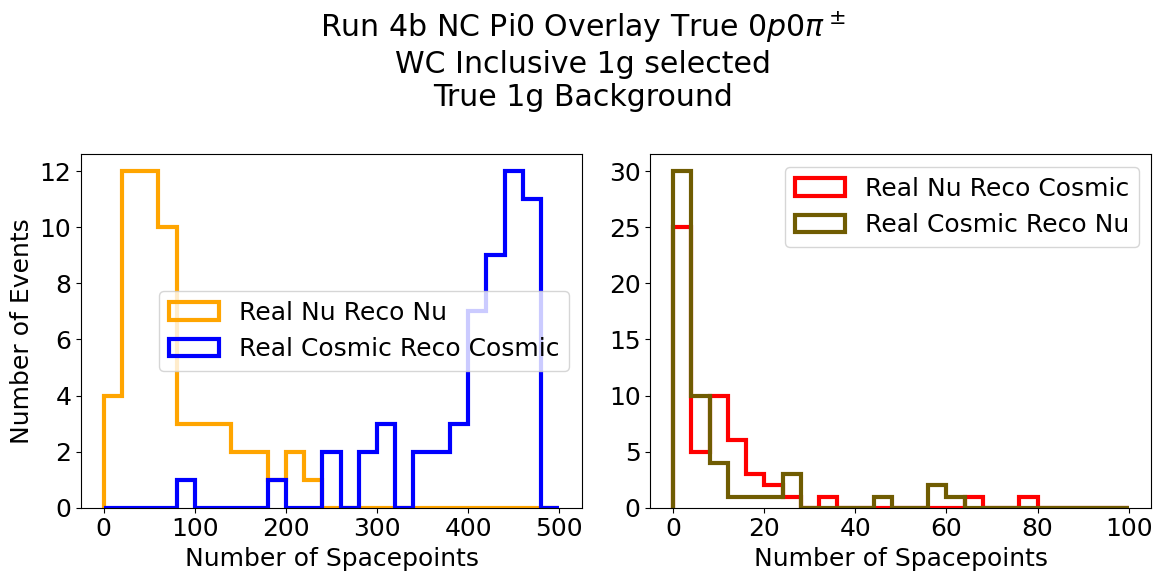

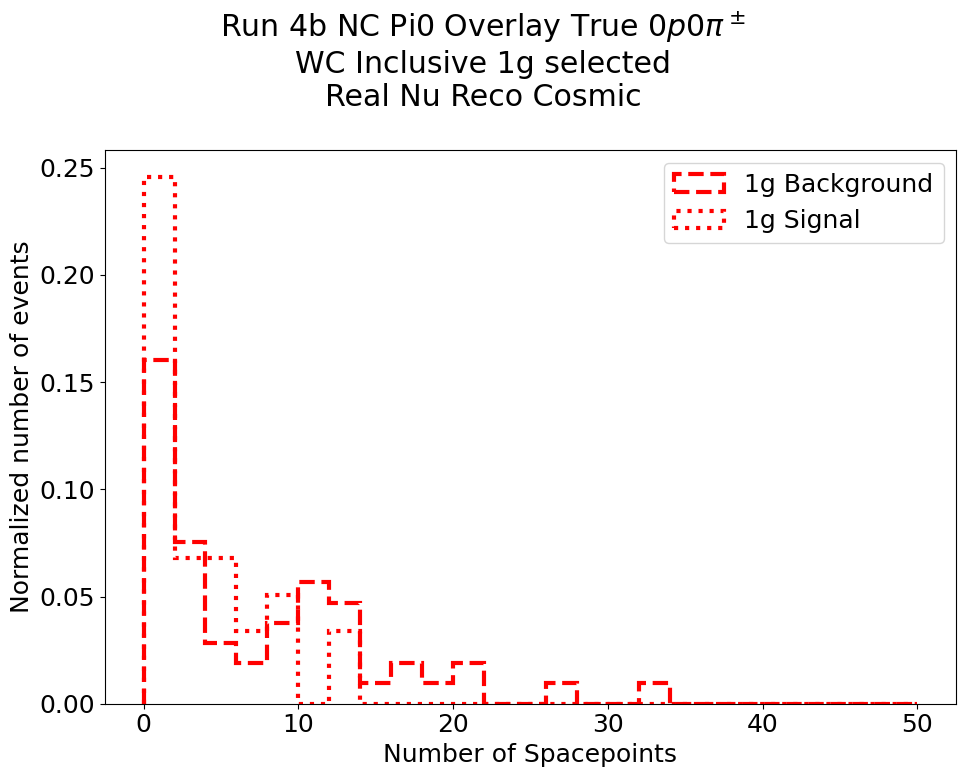

In [18]:
bins_correct = np.linspace(0, 500, 26)
bins_incorrect = np.linspace(0, 100, 26)
lw = 3

plt.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(inclusive_sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(inclusive_sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(inclusive_sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(inclusive_sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
if use_only_true_0p0pipm:
    plt.suptitle(r"Run 4b NC Pi0 Overlay True $0p0\pi^\pm$""\nWC Inclusive 1g selected")
else:
    plt.suptitle("Run 4b NC Pi0 Overlay\nWC Inclusive 1g selected")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(inclusive_sig_sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(inclusive_sig_sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(inclusive_sig_sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(inclusive_sig_sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
if use_only_true_0p0pipm:
    plt.suptitle(r"Run 4b NC Pi0 Overlay True $0p0\pi^\pm$""\nWC Inclusive 1g selected\nTrue 1g Signal")
else:
    plt.suptitle("Run 4b NC Pi0 Overlay\nWC Inclusive 1g selected\nTrue 1g Signal")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(inclusive_bkg_sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(inclusive_bkg_sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(inclusive_bkg_sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(inclusive_bkg_sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
if use_only_true_0p0pipm:
    plt.suptitle(r"Run 4b NC Pi0 Overlay True $0p0\pi^\pm$""\nWC Inclusive 1g selected\nTrue 1g Background")
else:
    plt.suptitle("Run 4b NC Pi0 Overlay\nWC Inclusive 1g selected\nTrue 1g Background")
plt.tight_layout()
plt.show()

bins = np.linspace(0, 50, 26)
plt.figure(figsize=(10, 8))
plt.hist(inclusive_bkg_sel_real_nu_reco_cosmic, bins=bins, histtype='step', density=True, lw=lw, color='red', ls='--', label='1g Background')
plt.hist(inclusive_sig_sel_real_nu_reco_cosmic, bins=bins, histtype='step', density=True, lw=lw, color='red', ls=':', label='1g Signal')
plt.legend()
plt.xlabel('Number of Spacepoints')
plt.ylabel("Normalized number of events")
if use_only_true_0p0pipm:
    plt.suptitle(r"Run 4b NC Pi0 Overlay True $0p0\pi^\pm$""\nWC Inclusive 1g selected\nReal Nu Reco Cosmic")
else:
    plt.suptitle("Run 4b NC Pi0 Overlay\nWC Inclusive 1g selected\nReal Nu Reco Cosmic")
plt.tight_layout()
plt.show()


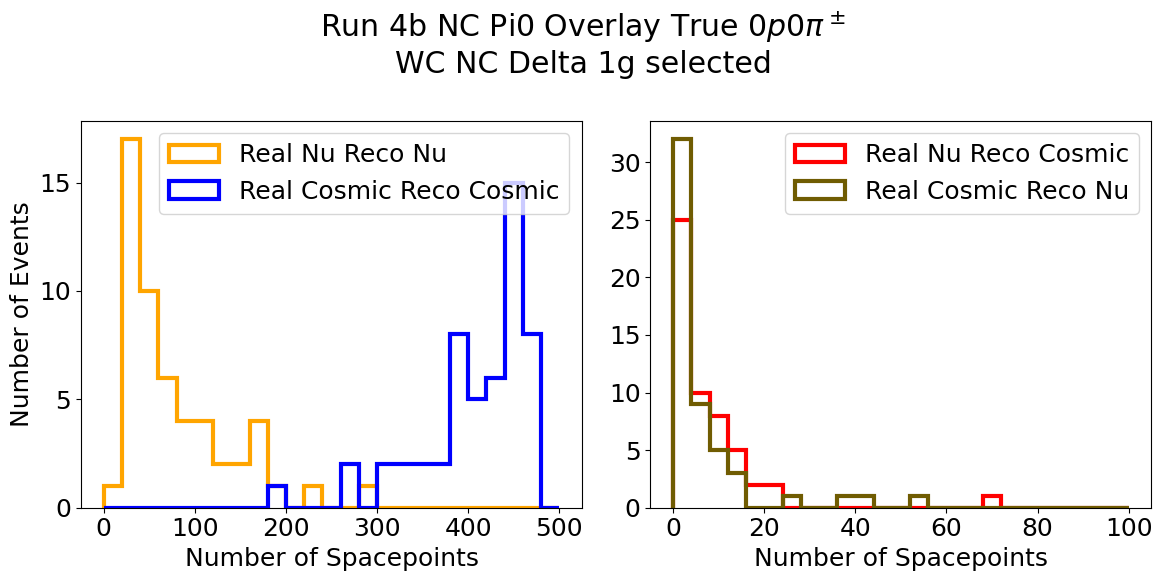

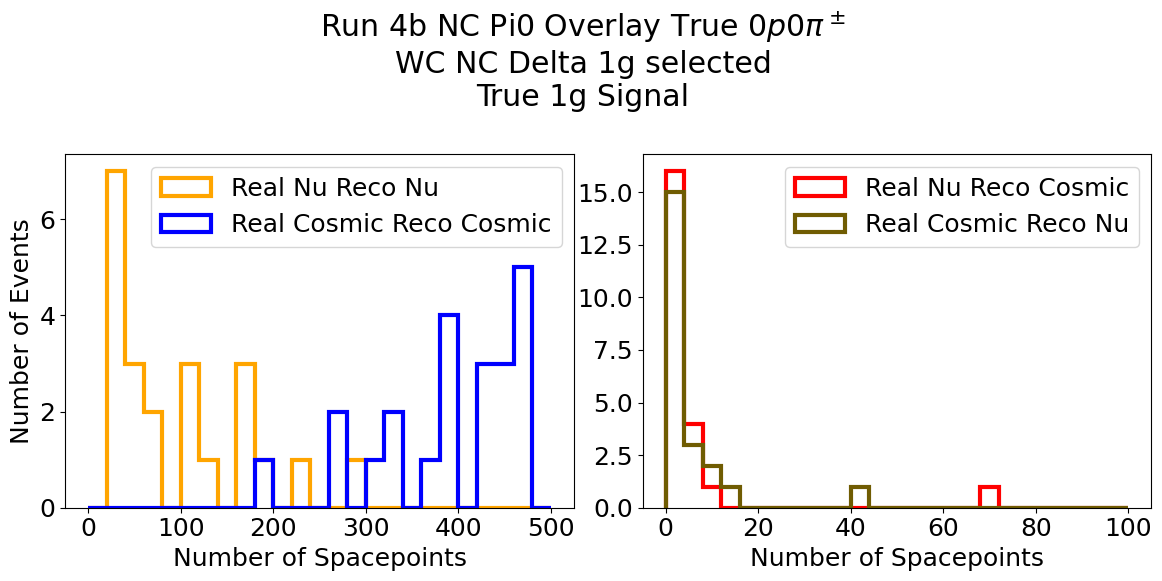

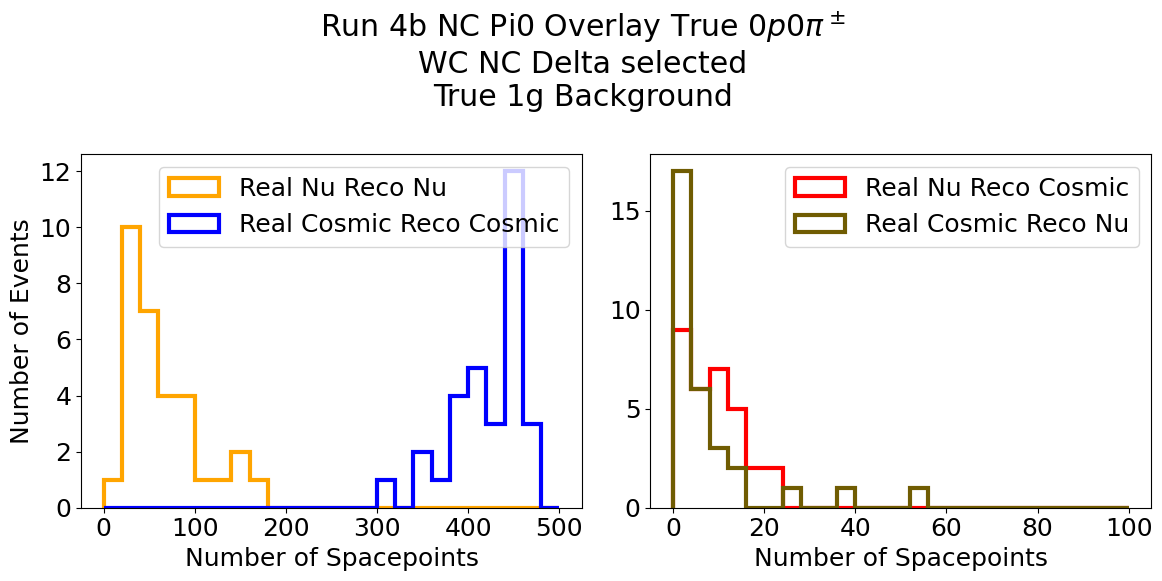

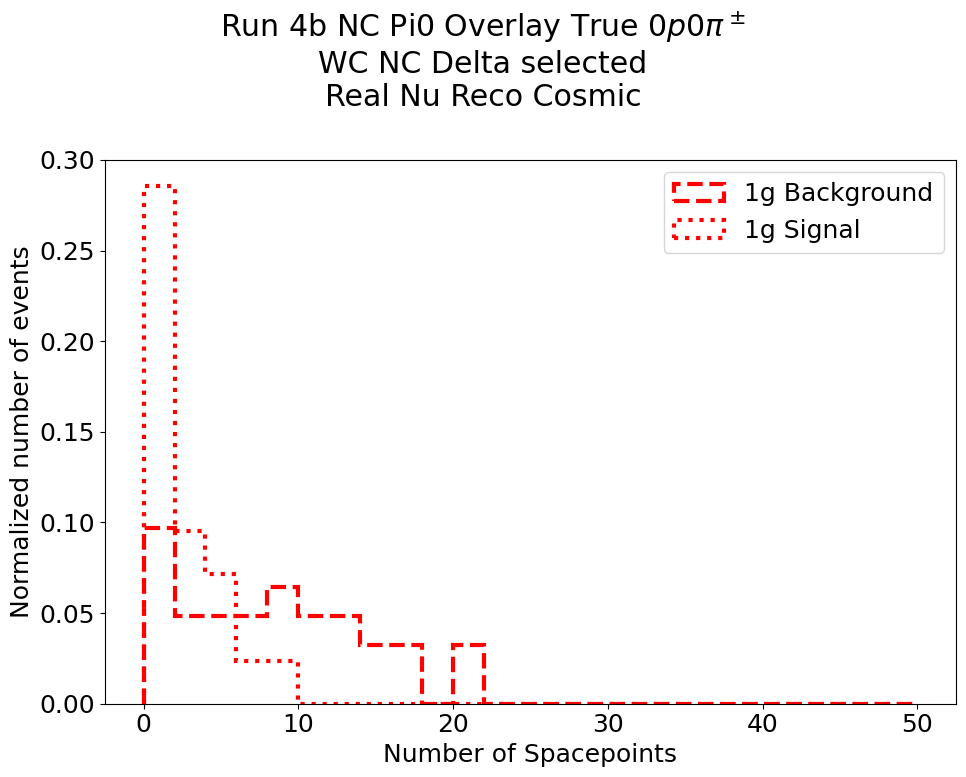

In [19]:
bins_correct = np.linspace(0, 500, 26)
bins_incorrect = np.linspace(0, 100, 26)
lw = 3

plt.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(nc_delta_sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(nc_delta_sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(nc_delta_sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(nc_delta_sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
if use_only_true_0p0pipm:
    plt.suptitle(r"Run 4b NC Pi0 Overlay True $0p0\pi^\pm$""\nWC NC Delta 1g selected")
else:
    plt.suptitle("Run 4b NC Pi0 Overlay\nWC NC Delta 1g selected")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(nc_delta_sig_sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(nc_delta_sig_sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(nc_delta_sig_sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(nc_delta_sig_sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
if use_only_true_0p0pipm:
    plt.suptitle(r"Run 4b NC Pi0 Overlay True $0p0\pi^\pm$""\nWC NC Delta 1g selected\nTrue 1g Signal")
else:
    plt.suptitle("Run 4b NC Pi0 Overlay\nWC NC Delta 1g selected\nTrue 1g Signal")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(nc_delta_bkg_sel_real_nu_reco_nu, bins=bins_correct, histtype='step', lw=lw, color='orange', label='Real Nu Reco Nu')
axs[0].hist(nc_delta_bkg_sel_real_cosmic_reco_cosmic, bins=bins_correct, histtype='step', lw=lw, color='blue', label='Real Cosmic Reco Cosmic')
axs[0].legend()
axs[0].set_xlabel('Number of Spacepoints')
axs[0].set_ylabel('Number of Events')
axs[1].hist(nc_delta_bkg_sel_real_nu_reco_cosmic, bins=bins_incorrect, histtype='step', lw=lw, color='red', label='Real Nu Reco Cosmic')
axs[1].hist(nc_delta_bkg_sel_real_cosmic_reco_nu, bins=bins_incorrect, histtype='step', lw=lw, color='#705c02', label='Real Cosmic Reco Nu')
axs[1].legend()
axs[1].set_xlabel('Number of Spacepoints')
if use_only_true_0p0pipm:
    plt.suptitle(r"Run 4b NC Pi0 Overlay True $0p0\pi^\pm$""\nWC NC Delta selected\nTrue 1g Background")
else:
    plt.suptitle("Run 4b NC Pi0 Overlay\nWC NC Delta selected\nTrue 1g Background")
plt.tight_layout()
plt.show()

bins = np.linspace(0, 50, 26)
plt.figure(figsize=(10, 8))
plt.hist(nc_delta_bkg_sel_real_nu_reco_cosmic, bins=bins, histtype='step', density=True, lw=lw, color='red', ls='--', label='1g Background')
plt.hist(nc_delta_sig_sel_real_nu_reco_cosmic, bins=bins, histtype='step', density=True, lw=lw, color='red', ls=':', label='1g Signal')
plt.legend()
plt.xlabel('Number of Spacepoints')
plt.ylabel("Normalized number of events")
if use_only_true_0p0pipm:
    plt.suptitle(r"Run 4b NC Pi0 Overlay True $0p0\pi^\pm$""\nWC NC Delta selected\nReal Nu Reco Cosmic")
else:
    plt.suptitle("Run 4b NC Pi0 Overlay\nWC NC Delta selected\nReal Nu Reco Cosmic")
plt.tight_layout()
plt.show()


# Plot in 3D

In [20]:
rse = wc_inclusive_1g_sel_df[["run", "subrun", "event"]].to_numpy()

include_non_downsampled_points = True

index = 1

run = either_1g_sel_df["run"].to_numpy()[index]
subrun = either_1g_sel_df["subrun"].to_numpy()[index]
event = either_1g_sel_df["event"].to_numpy()[index]

print("run, subrun, event:", run, subrun, event)

true_nu_vtx = wc_inclusive_1g_sel_df[["truth_vtxX", "truth_vtxY", "truth_vtxZ"]].to_numpy()[index, :]
reco_nu_vtx = wc_inclusive_1g_sel_df[["reco_nuvtxX", "reco_nuvtxY", "reco_nuvtxZ"]].to_numpy()[index, :]

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]])

# these are only added to set the camera at a better position
fig.add_trace(go.Scatter3d(
    x=expanded_detector_boundary_points[:, 2],
    y=expanded_detector_boundary_points[:, 0],
    z=expanded_detector_boundary_points[:, 1],
    mode='markers',
    marker=dict(
        size=0.2,
        color='black',
        opacity=0.8
    ),
    name='Expanded TPC Boundary'
))

fig.add_trace(go.Scatter3d(
    x=detector_boundary_points[:, 2],
    y=detector_boundary_points[:, 0],
    z=detector_boundary_points[:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color='black',
        opacity=0.8
    ),
    name='TPC Boundary'
))

fig.add_trace(go.Scatter3d(
    x=[reco_nu_vtx[2]],
    y=[reco_nu_vtx[0]],
    z=[reco_nu_vtx[1]],
    mode='markers',
    marker=dict(size=10, color='purple', opacity=1),
    name='Reco Neutrino Vertex',
    visible='legendonly'
))

fig.add_trace(go.Scatter3d(
    x=[true_nu_vtx[2]],
    y=[true_nu_vtx[0]],
    z=[true_nu_vtx[1]],
    mode='markers',
    marker=dict(size=10, color='green', opacity=1),
    name='True Neutrino Vertex',
    visible='legendonly'

))


if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=Tcluster_spacepoints[index][:, 2],
        y=Tcluster_spacepoints[index][:, 0],
        z=Tcluster_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color="blue",
            opacity=0.8
        ),
        name='Tcluster Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_Tcluster_spacepoints[index][:, 2],
    y=downsampled_Tcluster_spacepoints[index][:, 0],
    z=downsampled_Tcluster_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color="blue",
        opacity=0.8
    ),
    name='Downsampled Tcluster Spacepoints',
    visible='legendonly'
))

if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=Trec_spacepoints[index][:, 2],
        y=Trec_spacepoints[index][:, 0],
        z=Trec_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color='red',
            opacity=0.8
        ),
        name='Trec Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_Trec_spacepoints[index][:, 2],
    y=downsampled_Trec_spacepoints[index][:, 0],
    z=downsampled_Trec_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    ),
    name='Downsampled Trec Spacepoints',
    visible='legendonly'
))

if include_non_downsampled_points:
    fig.add_trace(go.Scatter3d(
        x=TrueEDep_spacepoints[index][:, 2],
        y=TrueEDep_spacepoints[index][:, 0],
        z=TrueEDep_spacepoints[index][:, 1],
        mode='markers',
        marker=dict(
            size=1,
            color='orange',
            opacity=0.8
        ),
        name='TrueEDep Spacepoints',
        visible='legendonly'
    ))

fig.add_trace(go.Scatter3d(
    x=downsampled_TrueEDep_spacepoints[index][:, 2],
    y=downsampled_TrueEDep_spacepoints[index][:, 0],
    z=downsampled_TrueEDep_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='orange',
        opacity=0.8
    ),
    name='Downsampled TrueEDep Spacepoints',
    visible='legendonly'
))

fig.add_trace(go.Scatter3d(
    x=real_nu_reco_nu_downsampled_spacepoints[index][:, 2],
    y=real_nu_reco_nu_downsampled_spacepoints[index][:, 0],
    z=real_nu_reco_nu_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='orange',
        opacity=0.8
    ),
    name='Real Nu Reco Nu Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 2],
    y=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 0],
    z=real_nu_reco_cosmic_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='red',
        opacity=0.8
    ),
    name='Real Nu Reco Cosmic Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 2],
    y=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 0],
    z=real_cosmic_reco_nu_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='brown',
        opacity=0.8
    ),
    name='Real Cosmic Reco Nu Spacepoints',
))

fig.add_trace(go.Scatter3d(
    x=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 2],
    y=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 0],
    z=real_cosmic_reco_cosmic_downsampled_spacepoints[index][:, 1],
    mode='markers',
    marker=dict(
        size=3,
        color='blue',
        opacity=0.8
    ),
    name='Real Cosmic Reco Cosmic Spacepoints',
))

fig.update_layout(
    scene=dict(
        xaxis_title='z',
        yaxis_title='x',
        zaxis_title='y',
        aspectratio=dict(
            x=5,
            y=3,
            z=1
        ),
    ),
    width=2000,
    height=1200,
    autosize=False,
    scene_camera=dict(
        eye=dict(x=-1.5, y=-1.5, z=1.5)
    )
)

fig.show(renderer="browser")


run, subrun, event: 20838 95 4782
